# OpSim -- the updated simulation notebook

## About

This notebook is for testing of the OpSim functionality.
An attempt was made to simplify code, so in most cases we
rely on the precalculated Sun trajectory and the solar
panel power output profile, loaded from files.

In [2]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import os
import sys

import numpy as np
import h5py

import yaml
import matplotlib.pyplot as plt
import simpy

print("Path:")
print("-------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')


# ---
import lusee        # Core lusee software
import nav          # Astro/observation wrapper classes
from   nav import *

import sim          # Simulation handler
import hardware     # hardware modules

#from hardware.parts import *; from hardware.panels import *;from hardware.controller import *; from hardware.battery import *

# ---

print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

Path:
-------------------------------------
/home/maxim/projects/lusee/opsim/notebooks
/home/maxim/projects/lusee/luseepy
/home/maxim/projects/lusee/opsim
/home/maxim/.virtualenvs/lusee/lib/python3.10/site-packages/backports
/usr/local/lib/python310.zip
/usr/local/lib/python3.10
/usr/local/lib/python3.10/lib-dynload
/home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages
simpy: 4.0.2, lusee: 1.2-dev, sim: 0.1


In [3]:
prefab_file = "../foo.hdf5"
f = h5py.File(prefab_file, "r")

ds_meta = f["/meta/configuration"]
conf    = yaml.safe_load(ds_meta[0,])
metadata= yaml.dump(conf)

print('-----------------------------------------------')
print(f'''*** Metadata in the file {prefab_file} ***''')
print('-----------------------------------------------')
print(metadata)

ds_data = f["/data/orbitals"]
da = np.array(ds_data[:]) # data arrat
print(f'''Shape of the data payload: {da.shape}''')

print('-----------------------------------------------')
print(f'''*** Data payload in the file {prefab_file} ***''')
print('-----------------------------------------------')
print(f'''Shape of the data payload: {da.shape}''')

# Print slices if necessary:
# print(data_array[0:3,1:2])
# print(data_array[:,1:2])
print(da[0:3,:])

-----------------------------------------------
*** Metadata in the file ../foo.hdf5 ***
-----------------------------------------------
location:
  height: 0
  latitude: -23.814
  longitude: 182.258
period:
  end: '2025-02-11 23:45:00'
  start: '2025-02-10 00:00:00'
satellites:
  elytra:
    aposelene_ref_time: '2024-05-01T00:00:00'
    argument_of_pericenter_deg: 72.625
    eccentricity: 0.56489
    inclination_deg: 57.097
    raan_deg: 0
    semi_major_km: 5738
  esa:
    aposelene_ref_time: '2024-05-01T00:00:00'
    argument_of_pericenter_deg: 72.625
    eccentricity: 0.56489
    inclination_deg: 57.097
    raan_deg: 0
    semi_major_km: 5738

Shape of the data payload: (192, 5)
-----------------------------------------------
*** Data payload in the file ../foo.hdf5 ***
-----------------------------------------------
Shape of the data payload: (192, 5)
[[ 6.07160000e+04 -8.57098031e-01  4.14527473e+00 -1.21136200e-01
   3.81562105e+00]
 [ 6.07160104e+04 -8.58802345e-01  4.14313183e

In [4]:
mySun = Sun(da[:,0], da[:,1] , da[:,2])
mySat = Sat(da[:,0], da[:,3] , da[:,4])

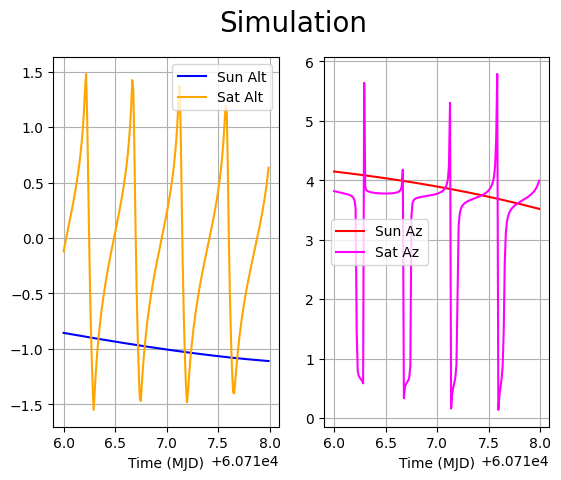

In [5]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")
p1.plot(mySat.mjd, mySat.alt,  color="orange", label="Sat Alt")

p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")
p2.plot(mySat.mjd, mySat.az, color="magenta",label="Sat Az")

p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()


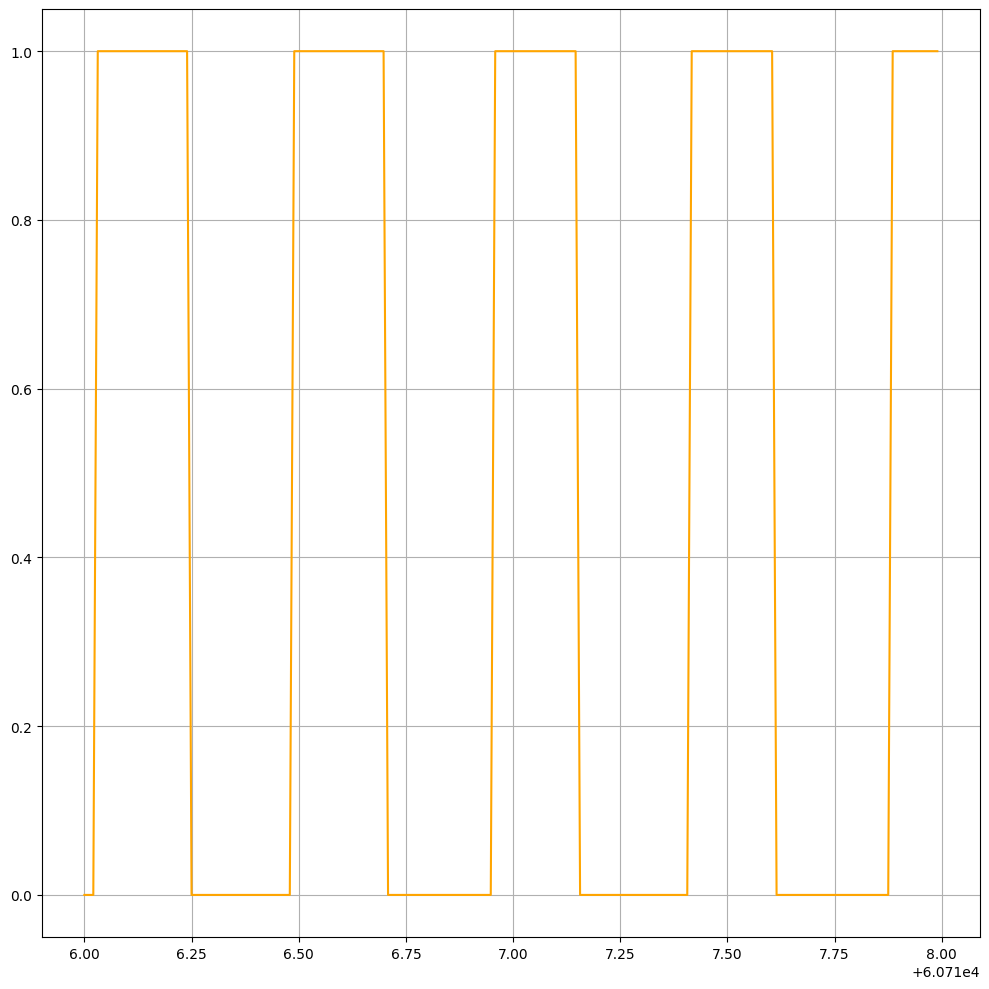

In [8]:
plt.rcParams["figure.figsize"] = [10., 10.]

ax=plt.subplot()
ax.plot(mySat.mjd, mySat.up,  color="orange", label="Sat Alt")
ax.grid(True)

---

### Initialize the Battery and Controller, create the power profile

Read the "panel exposure" data, such as prepared by the _prep-power_ script. This is essentially
the effective area as defined by the Sun position and geometry of the panels


In [3]:
env = simpy.Environment()

initial_charge, capacity = 100., 1200.
battery = Battery(env, initial_charge, capacity)

print(f'''Created a Battery with initial charge: {battery.level}, capacity: {battery.capacity}''')

mon = Monitor(mySun.N) # to define the discrete time axis
ctr = Controller(env, mySun, battery, mon)

Controller.verbose = True

ctr.add_all_panels()
# ctr.set_condition(mySun.condition)

ctr.calculate_power()


Created a Battery with initial charge: 100.0, capacity: 1200.0


In [ ]:

# ARCHIVE
# Controller.read_profile(power_cachefile)
### OPTIONAL (blocked by default)
# To check the numerical values -- can convert to a Python list: a = list(pwr) print(*a, sep = ", ").
# Or, print power values with the MJD timestamps.
if False:
    print(f'''Will attempt to access {mySun.N} points {Controller.profile}''')
    for i in range(0, mySun.N): print("%5.3f: %5.3f" % (mySun.mjd[i], Controller.profile[i]))


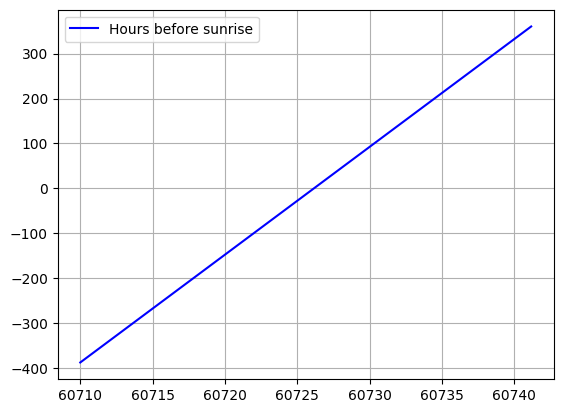

In [6]:
ax=plt.subplot()
ax.plot(mySun.mjd, hrs,                 color="blue",   label="Hours before sunrise")
plt.legend()
plt.grid(True)
plt.show()

Sunrise: 60726.145833333336
Checking efficiency array size: 2993


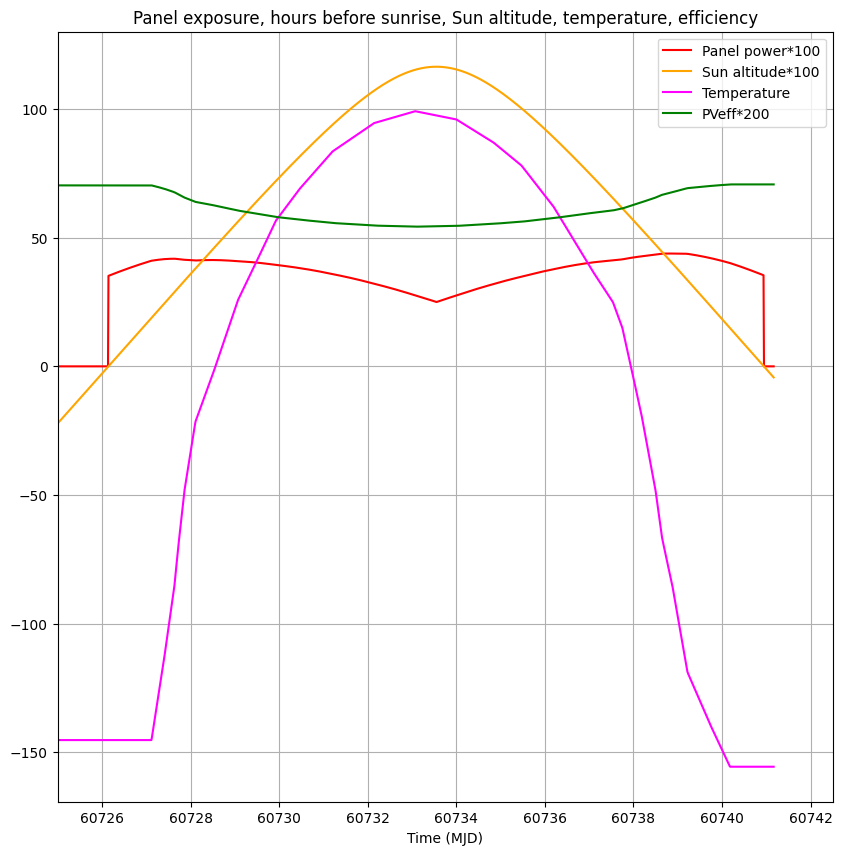

In [7]:
print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, ctr.power*100.,  color="red",    label="Panel power*100")
# ax.plot(mySun.mjd, hrs,                 color="blue",   label="Hours before sunrise")
ax.plot(mySun.mjd, mySun.alt*100,       color="orange", label="Sun altitude*100")
ax.plot(mySun.mjd, mySun.temperature,   color="Magenta",label="Temperature")

ax.set_xlabel('Time (MJD)')


eff = Panel.pvEfficiency(mySun.temperature)
print(f'''Checking efficiency array size: {eff.size}''')
ax.plot(mySun.mjd, eff*200., color="green",  label="PVeff*200")

plt.xlim(60725,60742.5)
# plt.ylim(-150,375)
plt.grid(True)
plt.title("Panel exposure, hours before sunrise, Sun altitude, temperature, efficiency")
plt.legend()

plt.show()


---

### Device properties

Device descriptions, such as states and power consumption for each state, can be stored in a _YAML_ file and read into the application.


In [9]:
# Read device configuration
import yaml

device_file = '../config/devices.yml'
print(f'''Reading device profiles from the file "{'../config/devices.yml'}"''')
f = open(device_file, 'r')

device_data = yaml.load(f, Loader=yaml.FullLoader)
profiles    = device_data['devices']
print(profiles.keys())



Reading device profiles from the file "../config/devices.yml"
dict_keys(['controller', 'comms'])


---

### Run the simulation

In [10]:
for device_name in profiles.keys():
    device = Device(device_name, profiles[device_name])
    ctr.add_device(device)

ctr.set_device_state('controller', 'ON')

print('List added devices:')
for added_device in ctr.devices.keys():
        dvc = ctr.devices[added_device]
        print(dvc.name, dvc.state)

env.process(ctr.run())
env.run(until=mySun.N)


List added devices:
controller ON
comms OFF


---

### Plot the results

In [ ]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD) - daytime')
p2.set_xlabel('Time (MJD)')

p1.plot(mySun.mjd, ctr.power,  color="blue",   label="Panel exposure (area units)")
p2.plot(mySun.mjd, ctr.monitor.battery, color="red",    label="Panel power (a.u.)")


p1.set_xlim([60725,60742.5])

p1.grid(True)
p2.grid(True)

plt.show()






---

## Archived utilities

Useful bits of code that aren't necesserily executed every time.


In [ ]:
# Pretty print the dictionary we read from the input YAML, for an extra check:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [ ]:
print('Current directory:', os.getcwd())

# Define files to configure the run:

conf_flnm   = '../config/conf.yml'
modes_flnm  = '../config/modes.yml'
devices_flnm= '../config/devices.yml'


print(f'''-------------------- {conf_flnm} ---------------------------------------------------''')
conf    = yaml.safe_load(open(conf_flnm, 'r'))
pretty(conf)


print(f'''-------------------- {modes_flnm} ---------------------------------------------------''')
modes   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(modes)


print(f'''-------------------- {devices_flnm} ---------------------------------------------------''')
devices   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(devices)
